# SPACEL workflow (1/3): Deconvolution by Spoint on mouse brain ST dataset

July 2023

Dataset: 75 ST slices of mouse brain ([here](https://zenodo.org/record/8167488))

In [4]:
import pandas as pd
import scanpy as sc
import anndata
import os
from tqdm import tqdm 
import scanpy as sc
import numpy as np
import sys

## Load spatial transcriptomics data

The input data are anndata objects stored raw counts for scRNA-seq and ST. The scRNA-seq anndata must have cell type annotation in ``.obs``.

In [5]:
adata = sc.read('/data/KanCell-main/docs/data/melanoma/Spatial.h5ad')
scadata = sc.read_h5ad('/data/KanCell-main/docs/data/melanoma/scRNA.h5ad')

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [9]:
scadata.var_names_make_unique()
scadata.obs_names_make_unique()

In [10]:
scadata

AnnData object with n_obs × n_vars = 4139 × 14515
    obs: 'CellType'
    var: 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [11]:
scadata.obs['CellType']

CELL_CY72.CD45.H02.S758.COMB                TYPE_B cells
CELL_CY58.1.CD45.B02.S974.COMB          TYPE_CD8 T cells
CELL_CY71.CD45.D08.S524.COMB         TYPE_Melanoma cells
CELL_CY81.FNA.CD45.B01.S301.COMB     TYPE_Melanoma cells
CELL_CY80.II.CD45.B07.S883.COMB      TYPE_Melanoma cells
                                            ...         
CELL_CY75.1.CD45.CD8.1..S25.COMB        TYPE_CD8 T cells
CELL_CY75.1.CD45.CD8.7..S223.COMB       TYPE_CD8 T cells
CELL_CY75.1.CD45.CD8.1..S65.COMB        TYPE_CD8 T cells
CELL_CY75.1.CD45.CD8.1..S93.COMB        TYPE_CD8 T cells
CELL_CY75.1.CD45.CD8.1..S76.COMB        TYPE_CD8 T cells
Name: CellType, Length: 4139, dtype: category
Categories (8, object): ['TYPE_B cells', 'TYPE_CD4 T cells', 'TYPE_CD8 T cells', 'TYPE_Endothelial cells', 'TYPE_Fibroblasts', 'TYPE_Macrophages', 'TYPE_Melanoma cells', 'TYPE_NK cells']

## Initialize and train the Spoint model

In this step, we initialize the Spoint model using anndata objects for scRNA-seq and ST as input. The``celltype_key`` parameter represents the column name of the cell type annotation in the .obs attribute of the scRNA-seq anndata object. The ``sm_size`` parameter controls the number of simulated spots, and it is important to have a sufficient ``sm_size`` for accurate prediction. However, it should be noted that increasing the ``sm_size`` will also increase the simulation and training time. In general, we recommend setting ``sm_size`` to a value greater than 100,000.

In [13]:
import KanCell
from Kancell.setting import set_environ_seed
set_environ_seed()
from KanCell import Spoint

Setting environment seed: 42


Global seed set to 0


In [14]:
import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
spoint_model = Spoint.init_model(scadata,adata,celltype_key='CellType',sm_size=500000,use_gpu=True,n_threads=16)

Setting global seed: 42
### Finding marker genes...
CellType
TYPE_B cells              200
TYPE_CD4 T cells          200
TYPE_CD8 T cells          200
TYPE_Endothelial cells    200
TYPE_Fibroblasts          200
TYPE_Macrophages          200
TYPE_Melanoma cells       200
TYPE_NK cells             200
Name: count, dtype: int64
### Used gene numbers: 1408
### Initializing sample probability
### Genetating simulated spatial data using scRNA data with mode: unbalance
### Genetating simulated spatial data using scRNA data with mode: sqrt
### Genetating simulated spatial data using scRNA data with mode: balance


In [15]:
import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
spoint_model.train(max_steps=5000, batch_size=1024)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/100:   1%|          | 1/100 [00:09<15:44,  9.55s/it, loss=1.38e+03, v_num=1]

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/100: 100%|██████████| 100/100 [14:48<00:00,  8.91s/it, loss=1.21e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [14:48<00:00,  8.88s/it, loss=1.21e+03, v_num=1]


Step 5000: Test inference loss=-0.975: 100%|██████████| 5000/5000 [25:45<00:00,  3.23it/s]


Then, we utilize the trained model to predict the cell type composition of each spot in the spatial transcriptomics data. This prediction will generate a DataFrame object, where each row corresponds to a spot in the spatial transcriptomics data, each column represents a cell type from the single-cell RNA-seq data, and each entry indicates the proportion of a particular cell type in a spot. Additionally, we can obtain the anndata object of the spatial transcriptomics data with the deconvolution results embedded in the .obs attribute.

In [16]:
pre = spoint_model.deconv_spatial()
st_ad = spoint_model.st_ad
# st_ad.write('../data/ST_mouse_brain/mouse_brain_st.h5ad')

## Visualization results

As a demonstration, we plotted the predicted compositions of cell types on a slice, where the cell types are selected as the top 20 with the highest proportion within each spot.

In [17]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(4,4))
sc.settings.verbosity = 3

In [19]:
pre = spoint_model.deconv_spatial()
celltype = st_ad.obs.loc[:,pre.columns].max(0)

In [20]:
st_ad = spoint_model.st_ad

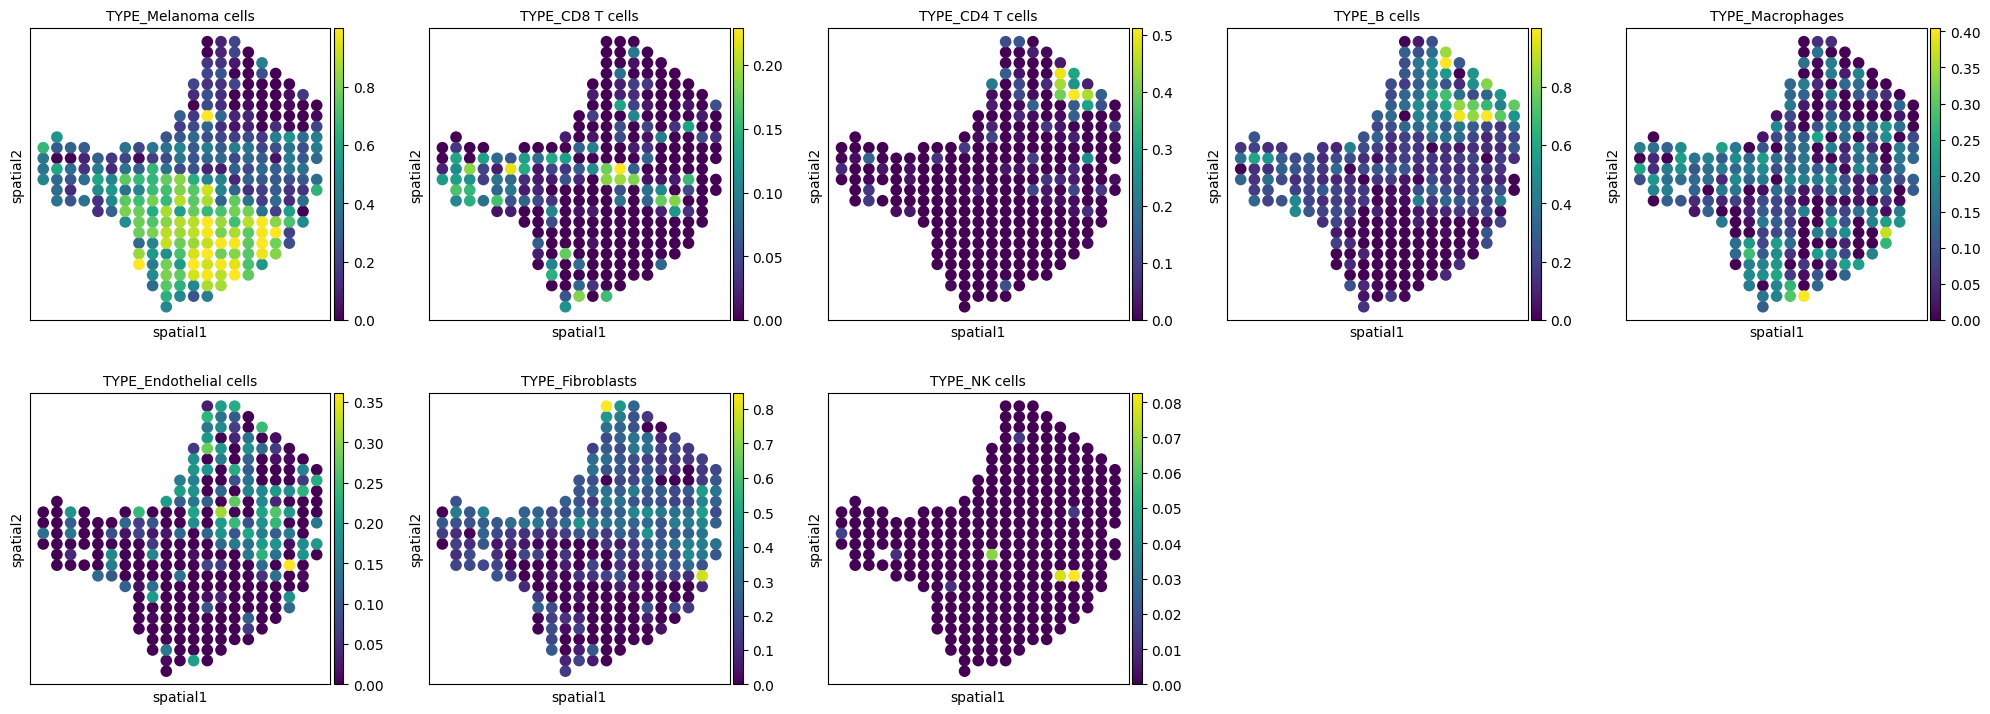

In [21]:
sc.pl.embedding(st_ad,color=pre.columns[:20],basis='spatial',ncols=5,s=280)

In [30]:
st_ad

AnnData object with n_obs × n_vars = 293 × 1408
    obs: 'n_genes', 'batch', 'TYPE_Melanoma cells', 'TYPE_CD8 T cells', 'TYPE_CD4 T cells', 'TYPE_B cells', 'TYPE_Macrophages', 'TYPE_Endothelial cells', 'TYPE_Fibroblasts', 'TYPE_NK cells'
    var: 'n_cells'
    uns: 'log1p', 'celltypes'
    obsm: 'spatial'
    layers: 'norm'

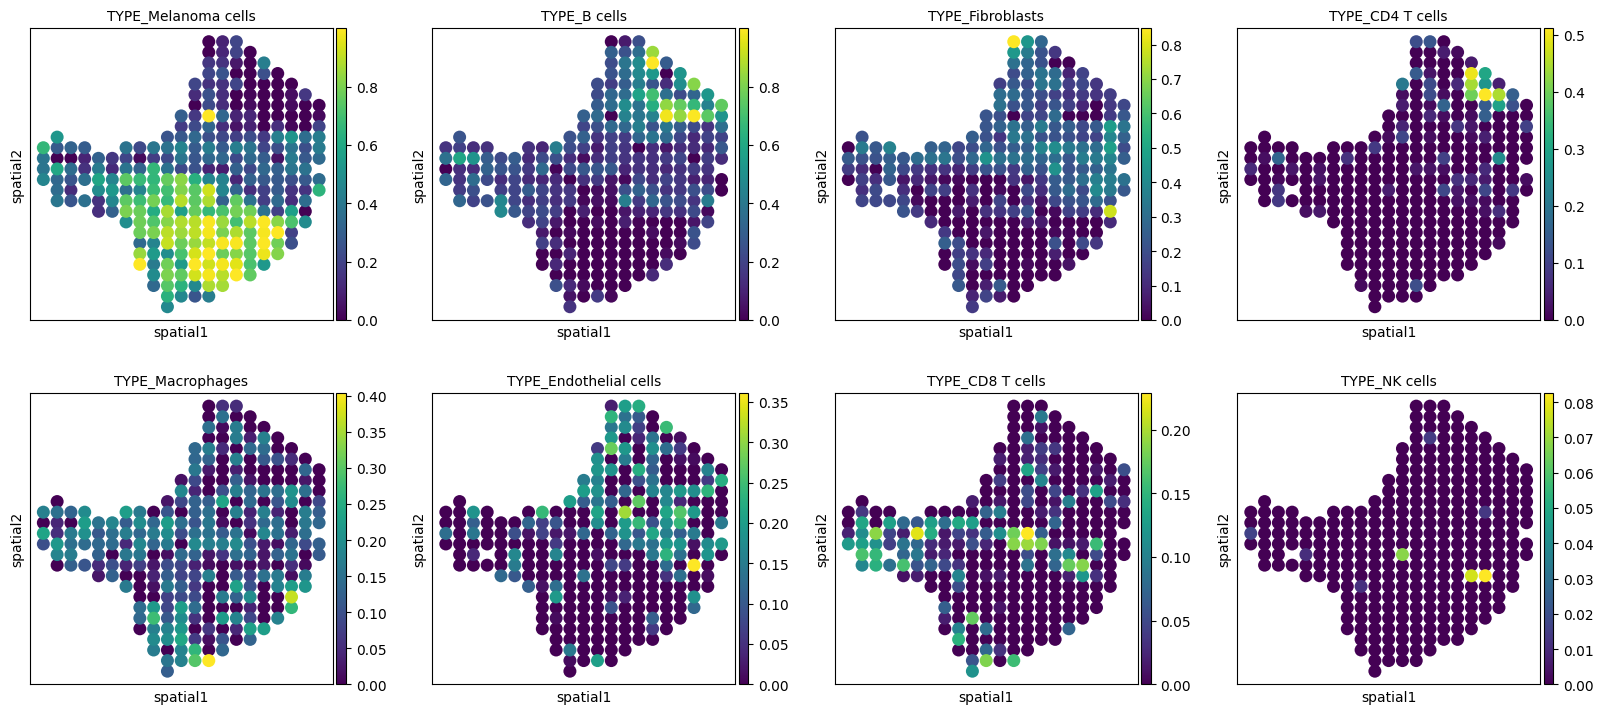

<Figure size 200x200 with 0 Axes>

In [22]:
import scanpy as sc
import matplotlib.pyplot as plt


# 假设 st_ad 是已经加载好的 AnnData 对象，并且 celltype 是您感兴趣的细胞类型列
# 更新字体大小
plt.rcParams.update({'font.size': 14})  # 设置全局字体大小
# 绘制embedding图
sc.pl.embedding(st_ad, color=celltype.sort_values(ascending=False)[:20].index, basis='spatial', ncols=4,s=350, size=10)
# 调整每个子图的字体大小
fig = plt.gcf()
axes = fig.get_axes()
for ax in axes:
    ax.title.set_size(30)  # 设置标题字体大小
    ax.xaxis.label.set_size(20)  # 设置x轴标签字体大小
    ax.yaxis.label.set_size(16)  # 设置y轴标签字体大小
    ax.tick_params(axis='both', which='major', labelsize=11)  # 设置刻度字体大小
# 显示图形
plt.show()



In [33]:
adata

AnnData object with n_obs × n_vars = 293 × 1408
    obs: 'n_genes', 'batch', 'TYPE_Melanoma cells', 'TYPE_CD8 T cells', 'TYPE_CD4 T cells', 'TYPE_B cells', 'TYPE_Macrophages', 'TYPE_Endothelial cells', 'TYPE_Fibroblasts', 'TYPE_NK cells'
    var: 'n_cells'
    uns: 'log1p', 'celltypes'
    obsm: 'spatial'
    layers: 'norm'

Tumor Region Summary Statistics
          n_genes  TYPE_Melanoma cells  TYPE_CD8 T cells  TYPE_CD4 T cells  \
count  102.000000           102.000000        102.000000        102.000000   
mean   200.509804             0.794498          0.011425          0.002244   
std     75.252281             0.133568          0.025756          0.014201   
min      1.000000             0.517048          0.000000          0.000000   
25%    151.250000             0.708467          0.000000          0.000000   
50%    196.000000             0.786241          0.000000          0.000000   
75%    253.750000             0.896136          0.000000          0.000000   
max    422.000000             0.999992          0.110211          0.121373   

       TYPE_B cells  TYPE_Macrophages  TYPE_Endothelial cells  \
count    102.000000        102.000000              102.000000   
mean       0.050732          0.086166                0.014208   
std        0.070794          0.080288                0.040180   
min  

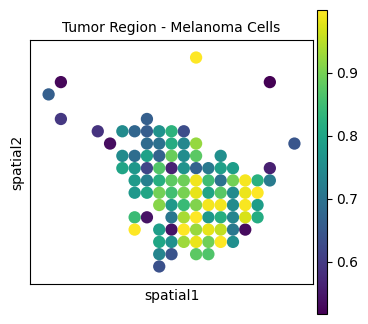

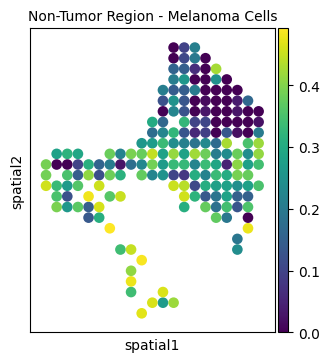

In [47]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# 加载AnnData对象

adata = st_ad

# 识别肿瘤和非肿瘤区域（根据'TYPE_Melanoma cells'的表达值）
tumor_cells = adata.obs['TYPE_Melanoma cells'] > 0.5
non_tumor_cells = adata.obs['TYPE_Melanoma cells'] <= 0.5

# 提取肿瘤和非肿瘤区域的数据
tumor_data = adata[tumor_cells]
non_tumor_data = adata[non_tumor_cells]

# 汇总统计肿瘤和非肿瘤区域的数据
tumor_summary = tumor_data.obs.describe()
non_tumor_summary = non_tumor_data.obs.describe()

print("Tumor Region Summary Statistics")
print(tumor_summary)

print("Non-Tumor Region Summary Statistics")
print(non_tumor_summary)

# 设置图像大小
figsize = (4, 4)  # 可以根据需要调整图像大小

# 绘制空间分布图，需要提供spot_size参数，并进行y轴翻转
spot_size = 1.0  # 可以根据需要调整spot_size的大小

# 翻转y轴以匹配提供的图片方向
fig, ax = plt.subplots(figsize=figsize)
sc.pl.spatial(tumor_data, color='TYPE_Melanoma cells', title='Tumor Region - Melanoma Cells', spot_size=spot_size, ax=ax, show=False)
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=figsize)
sc.pl.spatial(non_tumor_data, color='TYPE_Melanoma cells', title='Non-Tumor Region - Melanoma Cells', spot_size=spot_size, ax=ax, show=False)
ax.invert_yaxis()
plt.show()

# 保存统计结果为CSV文件
tumor_summary.to_csv("tumor_summary.csv")
non_tumor_summary.to_csv("non_tumor_summary.csv")


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


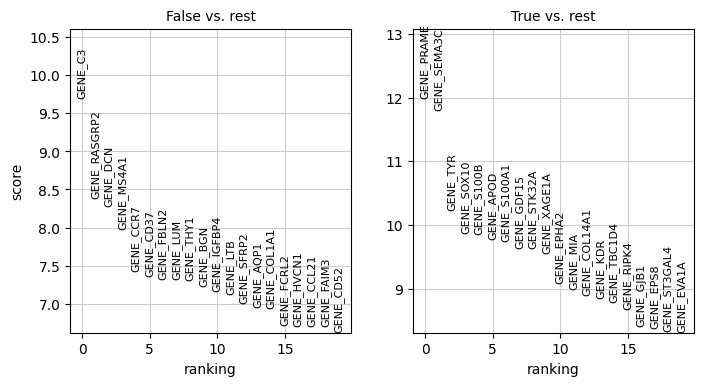

Tumor DE Genes: ['PRAME', 'SEMA3C', 'TYR', 'SOX10', 'S100B', 'APOD', 'S100A1', 'GDF15', 'STK32A', 'XAGE1A']
Non-Tumor DE Genes: ['C3', 'RASGRP2', 'DCN', 'MS4A1', 'CCR7', 'CD37', 'FBLN2', 'LUM', 'THY1', 'BGN']


In [65]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# 假设 st_ad 是已经加载好的 AnnData 对象，并且 celltype 是您感兴趣的细胞类型列
adata = st_ad

# 计算高变基因
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

# 筛选高变基因
adata = adata[:, adata.var.highly_variable]

# 归一化和对数转换
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 识别肿瘤和非肿瘤区域
adata.obs['tumor'] = (adata.obs['TYPE_Melanoma cells'] > 0.5).astype('category')

# 差异表达分析
sc.tl.rank_genes_groups(adata, 'tumor', method='t-test')

# 可视化差异表达基因
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
plt.rcParams.update({'font.size': 14})
plt.show()

# 提取肿瘤区域显著差异表达基因并去除前缀
tumor_de_genes = adata.uns['rank_genes_groups']['names']['True']
tumor_de_genes = [gene.replace('GENE_', '') for gene in tumor_de_genes if gene is not None]

# 提取非肿瘤区域显著差异表达基因并去除前缀
non_tumor_de_genes = adata.uns['rank_genes_groups']['names']['False']
non_tumor_de_genes = [gene.replace('GENE_', '') for gene in non_tumor_de_genes if gene is not None]

# 打印前10个基因名称，确保格式正确
print("Tumor DE Genes:", tumor_de_genes[:10])
print("Non-Tumor DE Genes:", non_tumor_de_genes[:10])


          Gene_set                               Term Overlap       P-value  \
0  KEGG_2021_Human         Hematopoietic cell lineage   52/99  8.479338e-34   
1  KEGG_2021_Human            Cell adhesion molecules  54/148  3.477206e-25   
2  KEGG_2021_Human   Th1 and Th2 cell differentiation   38/92  2.475552e-20   
3  KEGG_2021_Human                      Leishmaniasis   34/77  1.878085e-19   
4  KEGG_2021_Human           Type I diabetes mellitus   24/43  3.959261e-17   
5  KEGG_2021_Human    Staphylococcus aureus infection   35/95  5.884980e-17   
6  KEGG_2021_Human  B cell receptor signaling pathway   32/81  1.165922e-16   
7  KEGG_2021_Human                Allograft rejection   22/38  2.818848e-16   
8  KEGG_2021_Human          Graft-versus-host disease   23/42  3.192627e-16   
9  KEGG_2021_Human          Th17 cell differentiation  36/107  6.098609e-16   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      2.416611e-31            0                     0   15.

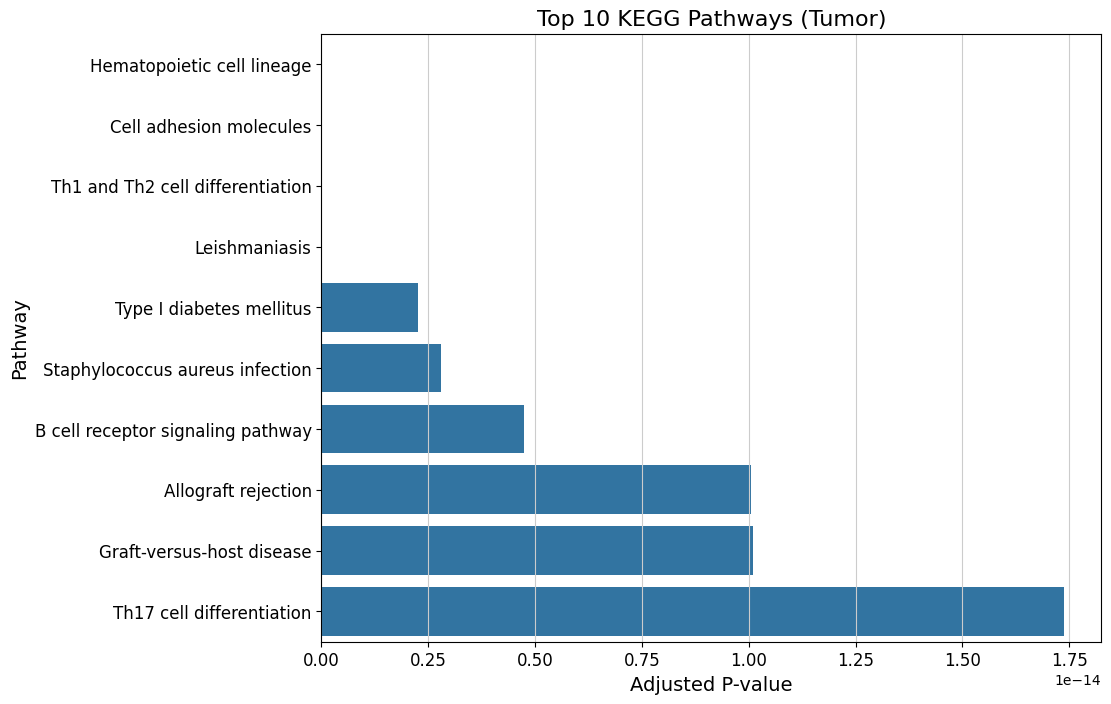

In [66]:
import gseapy as gp
import seaborn as sns

# 使用gseapy进行KEGG通路富集分析（肿瘤区域）
tumor_enr = gp.enrichr(gene_list=tumor_de_genes, gene_sets='KEGG_2021_Human', outdir=None)

# 确认富集分析结果（肿瘤区域）
print(tumor_enr.results.head(10))  # 打印前10个富集分析结果

# 可视化前10个显著的KEGG通路（肿瘤区域）
if not tumor_enr.results.empty:
    tumor_enr_results = tumor_enr.results.head(10)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Adjusted P-value', y='Term', data=tumor_enr_results)
    plt.title('Top 10 KEGG Pathways (Tumor)', fontsize=16)
    plt.xlabel('Adjusted P-value', fontsize=14)
    plt.ylabel('Pathway', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
else:
    print("没有显著的KEGG通路（肿瘤区域）")


          Gene_set                               Term Overlap       P-value  \
0  KEGG_2021_Human         Hematopoietic cell lineage   52/99  8.479338e-34   
1  KEGG_2021_Human            Cell adhesion molecules  54/148  3.477206e-25   
2  KEGG_2021_Human   Th1 and Th2 cell differentiation   38/92  2.475552e-20   
3  KEGG_2021_Human                      Leishmaniasis   34/77  1.878085e-19   
4  KEGG_2021_Human           Type I diabetes mellitus   24/43  3.959261e-17   
5  KEGG_2021_Human    Staphylococcus aureus infection   35/95  5.884980e-17   
6  KEGG_2021_Human  B cell receptor signaling pathway   32/81  1.165922e-16   
7  KEGG_2021_Human                Allograft rejection   22/38  2.818848e-16   
8  KEGG_2021_Human          Graft-versus-host disease   23/42  3.192627e-16   
9  KEGG_2021_Human          Th17 cell differentiation  36/107  6.098609e-16   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      2.416611e-31            0                     0   15.

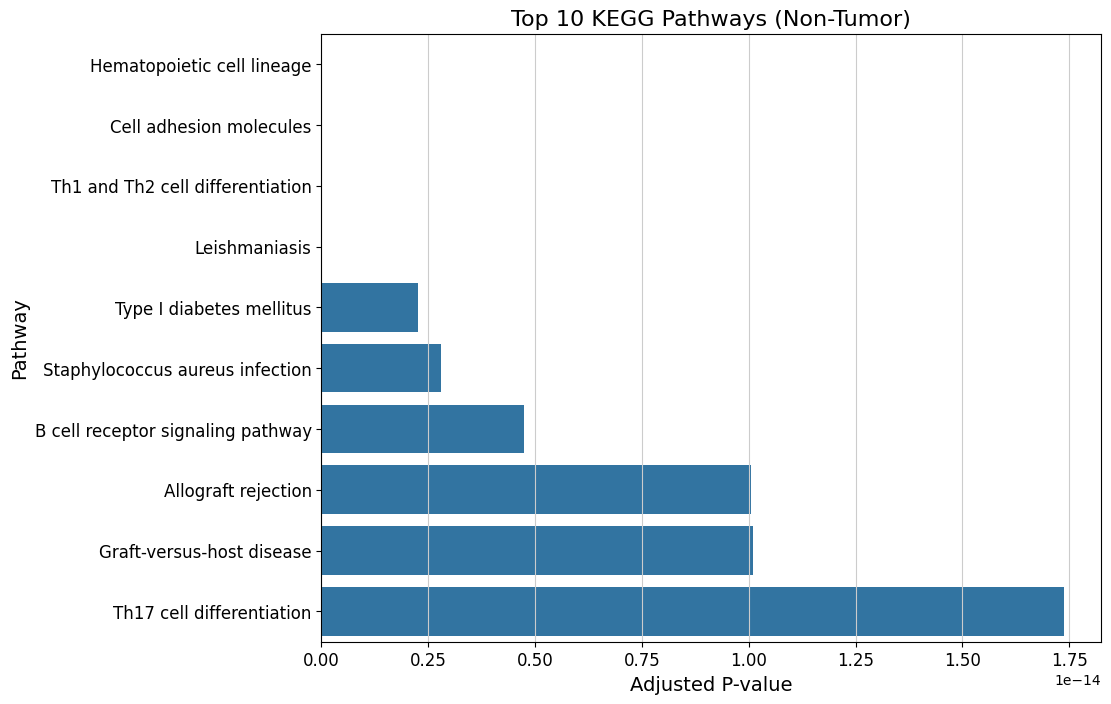

In [67]:
# 使用gseapy进行KEGG通路富集分析（非肿瘤区域）
non_tumor_enr = gp.enrichr(gene_list=non_tumor_de_genes, gene_sets='KEGG_2021_Human', outdir=None)

# 确认富集分析结果（非肿瘤区域）
print(non_tumor_enr.results.head(10))  # 打印前10个富集分析结果

# 可视化前10个显著的KEGG通路（非肿瘤区域）
if not non_tumor_enr.results.empty:
    non_tumor_enr_results = non_tumor_enr.results.head(10)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Adjusted P-value', y='Term', data=non_tumor_enr_results)
    plt.title('Top 10 KEGG Pathways (Non-Tumor)', fontsize=16)
    plt.xlabel('Adjusted P-value', fontsize=14)
    plt.ylabel('Pathway', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
else:
    print("没有显著的KEGG通路（非肿瘤区域）")


In [240]:
import scanpy as sc

# 确认已加载的 AnnData 对象
adata = st_ad

# 识别肿瘤和非肿瘤区域
adata.obs['tumor'] = (adata.obs['TYPE_Melanoma cells'] > 0.5).astype('category')

print(adata.obs['tumor'].value_counts())


tumor
False    191
True     102
Name: count, dtype: int64


In [161]:
# 计算高变基因
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

# 筛选高变基因
adata = adata[:, adata.var.highly_variable]

# 确认高变基因筛选结果
print(adata.var.highly_variable.value_counts())


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
highly_variable
True    1408
Name: count, dtype: int64


In [162]:
# 归一化和对数转换
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 计算高变基因后的统计信息
print(adata.X.shape)


normalizing counts per cell
    finished (0:00:00)
(293, 1408)


In [163]:
# 差异表达分析
sc.tl.rank_genes_groups(adata, 'tumor', method='t-test')

# 检查差异表达分析结果
print(adata.uns['rank_genes_groups'].keys())
print(adata.uns['rank_genes_groups']['names'].dtype)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])
(numpy.record, [('False', 'O'), ('True', 'O')])


In [169]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 提取肿瘤区域显著差异表达基因
de_results_tumor = pd.DataFrame({
    'gene': adata.uns['rank_genes_groups']['names']['True'],
    'logfoldchange': adata.uns['rank_genes_groups']['logfoldchanges']['True'],
    'pvals_adj': adata.uns['rank_genes_groups']['pvals_adj']['True'],
    'group': 'Tumor'
})

# 提取非肿瘤区域显著差异表达基因
de_results_non_tumor = pd.DataFrame({
    'gene': adata.uns['rank_genes_groups']['names']['False'],
    'logfoldchange': adata.uns['rank_genes_groups']['logfoldchanges']['False'],
    'pvals_adj': adata.uns['rank_genes_groups']['pvals_adj']['False'],
    'group': 'Non-Tumor'
})

# 合并数据，确保每个基因只保留一个组中的记录
de_results_combined = pd.concat([de_results_tumor, de_results_non_tumor])
de_results_combined = de_results_combined.sort_values(by='pvals_adj').drop_duplicates(subset='gene', keep='first')




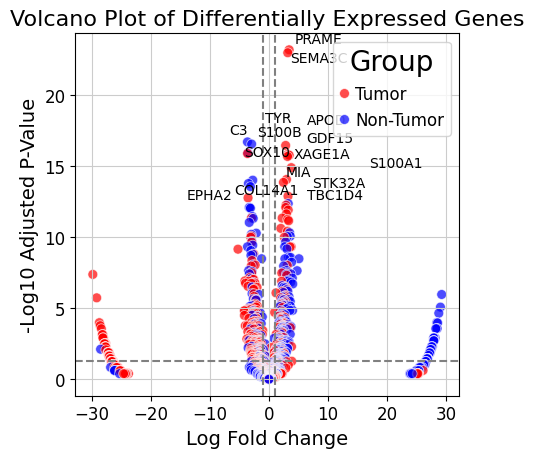

In [237]:
from adjustText import adjust_text
# 合并数据，确保每个基因只保留一个组中的记录
de_results_combined = pd.concat([de_results_tumor, de_results_non_tumor])
de_results_combined = de_results_combined.sort_values(by='pvals_adj').drop_duplicates(subset='gene', keep='first')

# 绘制火山图
plt.figure(figsize=(5, 5))  # 缩小图片尺寸
sns.scatterplot(data=de_results_combined, x='logfoldchange', y=-np.log10(de_results_combined['pvals_adj']),
                hue='group', palette={'Tumor': 'red', 'Non-Tumor': 'blue'}, alpha=0.7, s=50)  # 增大点的大小
plt.xlabel('Log Fold Change', fontsize=14)  # 增大字体
plt.ylabel('-Log10 Adjusted P-Value', fontsize=14)  # 增大字体
plt.title('Volcano Plot of Differentially Expressed Genes', fontsize=16)  # 增大标题字体
plt.axhline(-np.log10(0.05), color='gray', linestyle='--')
plt.axvline(1, color='gray', linestyle='--')
plt.axvline(-1, color='gray', linestyle='--')
plt.legend(title='Group', fontsize=12)  # 增大图例字体
plt.xticks(fontsize=12)  # 增大刻度字体
plt.yticks(fontsize=12)  # 增大刻度字体

# 标记显著基因的前15个
top_genes = de_results_combined.sort_values(by='pvals_adj').head(15)
texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['logfoldchange'], -np.log10(row['pvals_adj']), row['gene'], fontsize=10))

# 自动调整文本位置，避免重叠
adjust_text(texts)

plt.tight_layout()
plt.show()

filtered out 14 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:39)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:

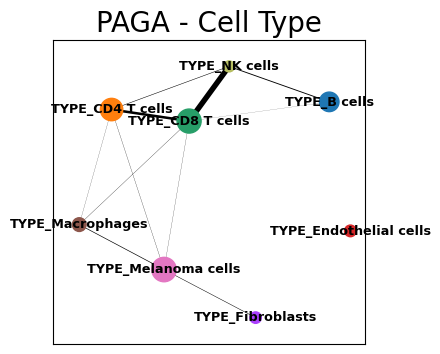

In [238]:
import scanpy as sc
import scvelo as scv
import pandas as pd
import matplotlib.pyplot as plt

# 假设 scadata 是已经加载的 AnnData 对象
adata = scadata.copy()

# 计算总计数和线粒体基因比例
adata.obs['total_counts'] = adata.X.sum(axis=1)
adata.obs['pct_counts_mt'] = (adata[:, adata.var_names.str.startswith('MT-')].X.sum(axis=1) / adata.obs['total_counts']) * 100

# 数据预处理
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

# PCA分析
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# 运行 PAGA
sc.tl.paga(adata, groups='CellType')

# 绘制 CellType 的 PAGA 图
fig, ax = plt.subplots(figsize=(4, 4))  # 调整图形尺寸
sc.pl.paga(adata, color='CellType', title='PAGA - Cell Type', ax=ax, show=False)
plt.title('PAGA - Cell Type', fontsize=20)  # 增大标题字体
ax.tick_params(axis='both', which='major', labelsize=16)  # 增大刻度字体
plt.savefig('paga_celltype.png')
plt.show()


computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


dpt_pseudotime has been added to adata.obs


<Figure size 500x400 with 0 Axes>

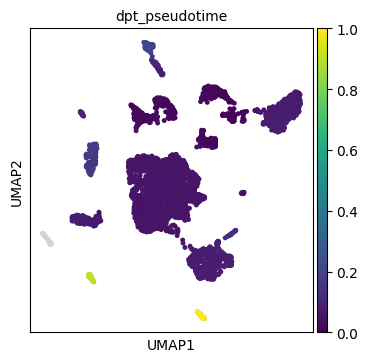

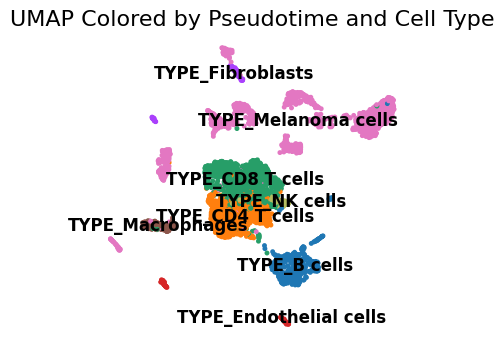

In [194]:
import scanpy as sc
import matplotlib.pyplot as plt

# 确保已经加载了必要的数据和模块
# 假设adata已经加载并包含所需的obs列

# 选择 TYPE_Melanoma cells 作为起点细胞类型
root_cells = adata[adata.obs['CellType'] == 'TYPE_Melanoma cells']
if root_cells.shape[0] > 0:
    root_cell_index = root_cells.obs.index[0]
    root_cell_pos = adata.obs.index.get_loc(root_cell_index)
    adata.uns['iroot'] = root_cell_pos

    # 进行伪时间分析
    sc.tl.dpt(adata, n_dcs=10)

    # 检查 dpt_pseudotime 是否在 adata.obs 中
    if 'dpt_pseudotime' in adata.obs:
        print("dpt_pseudotime has been added to adata.obs")
    else:
        print("dpt_pseudotime not found in adata.obs")
else:
    print("No TYPE_Melanoma cells found in the dataset.")

# 绘制 UMAP 图并根据伪时间对细胞进行颜色编码，同时使用形状区分不同的细胞类型
plt.figure(figsize=(10, 8))
sc.pl.umap(adata, color='dpt_pseudotime', size=50, show=False)
sc.pl.umap(adata, color='CellType', frameon=False, size=50, legend_loc='on data', legend_fontsize=12, show=False)
plt.title('UMAP Colored by Pseudotime and Cell Type', fontsize=16)
plt.show()


In [251]:
print(adata.obs['CellType'].unique())

['TYPE_B cells', 'TYPE_CD8 T cells', 'TYPE_Melanoma cells', 'TYPE_CD4 T cells', 'TYPE_Fibroblasts', 'TYPE_Macrophages', 'TYPE_Endothelial cells', 'TYPE_NK cells']
Categories (8, object): ['TYPE_B cells', 'TYPE_CD4 T cells', 'TYPE_CD8 T cells', 'TYPE_Endothelial cells', 'TYPE_Fibroblasts', 'TYPE_Macrophages', 'TYPE_Melanoma cells', 'TYPE_NK cells']


In [252]:
adata.obs['tumor']

CELL_CY72.CD45.H02.S758.COMB         False
CELL_CY58.1.CD45.B02.S974.COMB       False
CELL_CY71.CD45.D08.S524.COMB         False
CELL_CY81.FNA.CD45.B01.S301.COMB     False
CELL_CY80.II.CD45.B07.S883.COMB      False
                                     ...  
CELL_CY75.1.CD45.CD8.1..S25.COMB     False
CELL_CY75.1.CD45.CD8.7..S223.COMB    False
CELL_CY75.1.CD45.CD8.1..S65.COMB     False
CELL_CY75.1.CD45.CD8.1..S93.COMB     False
CELL_CY75.1.CD45.CD8.1..S76.COMB     False
Name: tumor, Length: 4139, dtype: category
Categories (1, bool): [False]

In [345]:
scadata.obs['CellType']

CELL_CY72.CD45.H02.S758.COMB                TYPE_B cells
CELL_CY58.1.CD45.B02.S974.COMB          TYPE_CD8 T cells
CELL_CY71.CD45.D08.S524.COMB         TYPE_Melanoma cells
CELL_CY81.FNA.CD45.B01.S301.COMB     TYPE_Melanoma cells
CELL_CY80.II.CD45.B07.S883.COMB      TYPE_Melanoma cells
                                            ...         
CELL_CY75.1.CD45.CD8.1..S25.COMB        TYPE_CD8 T cells
CELL_CY75.1.CD45.CD8.7..S223.COMB       TYPE_CD8 T cells
CELL_CY75.1.CD45.CD8.1..S65.COMB        TYPE_CD8 T cells
CELL_CY75.1.CD45.CD8.1..S93.COMB        TYPE_CD8 T cells
CELL_CY75.1.CD45.CD8.1..S76.COMB        TYPE_CD8 T cells
Name: CellType, Length: 4139, dtype: category
Categories (8, object): ['TYPE_B cells', 'TYPE_CD4 T cells', 'TYPE_CD8 T cells', 'TYPE_Endothelial cells', 'TYPE_Fibroblasts', 'TYPE_Macrophages', 'TYPE_Melanoma cells', 'TYPE_NK cells']

filtered out 14 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:38)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


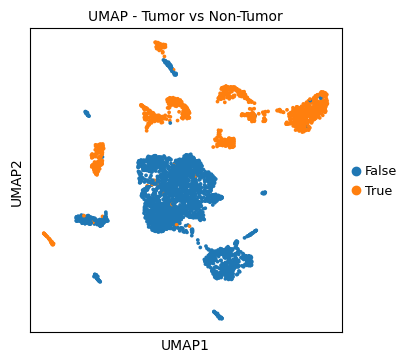

In [255]:
import scanpy as sc
import matplotlib.pyplot as plt

# 加载数据
adata = scadata.copy()

# 定义肿瘤标记
tumor_label = 'TYPE_Melanoma cells'

# 标记肿瘤和非肿瘤区域
adata.obs['tumor'] = (adata.obs['CellType'] == tumor_label).astype('category')

# 计算总计数和线粒体基因比例
adata.obs['total_counts'] = adata.X.sum(axis=1)
adata.obs['pct_counts_mt'] = (adata[:, adata.var_names.str.startswith('MT-')].X.sum(axis=1) / adata.obs['total_counts']) * 100

# 数据预处理
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

# PCA分析
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# 绘制UMAP图，显示肿瘤和非肿瘤区域
sc.pl.umap(adata, color='tumor', title='UMAP - Tumor vs Non-Tumor', save='umap_tumor_vs_nontumor.png')

In [300]:
# 差异基因表达分析：比较肿瘤和非肿瘤区域
sc.tl.rank_genes_groups(adata, 'tumor', method='wilcoxon', key_added='rank_genes_tumor_vs_nontumor')

# 提取肿瘤区域的差异基因列表并去掉前缀
tumor_genes = [gene.split('_')[-1] for gene in adata.uns['rank_genes_tumor_vs_nontumor']['names']['True'][:200]]  # 获取前200个差异基因
tumor_logfc = adata.uns['rank_genes_tumor_vs_nontumor']['logfoldchanges']['True'][:200]  # 提取logFC值
tumor_zscore = adata.uns['rank_genes_tumor_vs_nontumor']['scores']['True'][:200]  # 提取zscore值

# 提取非肿瘤区域的差异基因列表并去掉前缀
nontumor_genes = [gene.split('_')[-1] for gene in adata.uns['rank_genes_tumor_vs_nontumor']['names']['False'][:200]]  # 获取前200个差异基因
nontumor_logfc = adata.uns['rank_genes_tumor_vs_nontumor']['logfoldchanges']['False'][:200]  # 提取logFC值
nontumor_zscore = adata.uns['rank_genes_tumor_vs_nontumor']['scores']['False'][:200]  # 提取zscore值

# 使用g:Profiler进行富集分析
gp = GProfiler(return_dataframe=True)

# 确保传递的是基因列表
enrichment_tumor = gp.profile(organism='hsapiens', query=tumor_genes)
enrichment_nontumor = gp.profile(organism='hsapiens', query=nontumor_genes)


# 检查数据
print("Enrichment Tumor DataFrame:")
print(enrichment_tumor.head())

print("\nEnrichment Non-Tumor DataFrame:")
print(enrichment_nontumor.head())


ranking genes
    finished: added to `.uns['rank_genes_tumor_vs_nontumor']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
Enrichment Tumor DataFrame:
  source      native                              name   p_value  significant  \
0  GO:BP  GO:0032501  multicellular organismal process  0.000009         True   
1  GO:BP  GO:0065008  regulation of biological quality  0.000024         True   
2  GO:CC  GO:0071944                    cell periphery  0.000038         True   
3  GO:CC  GO:0005886                   plasma membrane  0.000145         True   
4  GO:BP  GO:0050896              response to stimulus  0.000169         True   

                                         description  term_size  query_size  \
0  "Any bio

In [308]:
# 使用g:Profiler进行富集分析
gp = GProfiler(return_dataframe=True)

# 确保传递的是基因列表
enrichment_tumor = gp.profile(organism='hsapiens', query=tumor_genes)
enrichment_nontumor = gp.profile(organism='hsapiens', query=nontumor_genes)

# 检查返回结果是否包含 intersection 列
print(enrichment_tumor.columns)
print(enrichment_nontumor.columns)

# 如果没有 intersection 列，检查 query 列是否包含基因列表
print(enrichment_tumor.head())
print(enrichment_nontumor.head())


Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', 'parents'],
      dtype='object')
Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', 'parents'],
      dtype='object')
  source      native                              name   p_value  significant  \
0  GO:BP  GO:0032501  multicellular organismal process  0.000009         True   
1  GO:BP  GO:0065008  regulation of biological quality  0.000024         True   
2  GO:CC  GO:0071944                    cell periphery  0.000038         True   
3  GO:CC  GO:0005886                   plasma membrane  0.000145         True   
4  GO:BP  GO:0050896              response to stimulus  0.000169         True   

                                         description  t

In [312]:

# 手动添加基因列表到返回结果中
enrichment_tumor['genes'] = ','.join(tumor_genes)
enrichment_nontumor['genes'] = ','.join(nontumor_genes)

# 处理logFC和zscore中的nan值
tumor_logfc = [0 if pd.isna(x) else x for x in tumor_logfc]
tumor_zscore = [0 if pd.isna(x) else x for x in tumor_zscore]
nontumor_logfc = [0 if pd.isna(x) else x for x in nontumor_logfc]
nontumor_zscore = [0 if pd.isna(x) else x for x in nontumor_zscore]

# 提取富集分析结果并保存为CSV文件
# 提取富集分析结果并保存为CSV文件
def save_enrichment_to_csv(enrichment_df, gene_list, logfc_list, zscore_list, filename):
    data = []
    logfc_dict = dict(zip(gene_list, logfc_list))  # 将基因和logFC值配对
    zscore_dict = dict(zip(gene_list, zscore_list))  # 将基因和zscore值配对

    for _, row in enrichment_df.iterrows():
        genes = row['genes'].split(',')  # 从'genes'列中提取基因列表
        for gene in genes:
            gene = gene.strip()  # 去掉可能存在的空格
            logfc = logfc_dict.get(gene, '')  # 获取对应基因的logFC值
            zscore = zscore_dict.get(gene, '')  # 获取对应基因的zscore值
            data.append([row['source'], row['native'], row['name'], row['intersection_size'], gene, logfc, row['p_value'], zscore])
    enrichment_data = pd.DataFrame(data, columns=['category', 'ID', 'term', 'count', 'genes', 'logFC', 'adj_pval', 'zscore'])
    enrichment_data.to_csv(filename, index=False)

# 保存肿瘤区域富集分析结果
save_enrichment_to_csv(enrichment_tumor, tumor_genes, tumor_logfc, tumor_zscore, '/data/SPACEL-l/docs/tutorials/xlsx/enrichment_tumor.csv')

# 保存非肿瘤区域富集分析结果
save_enrichment_to_csv(enrichment_tumor, tumor_genes, tumor_logfc, tumor_zscore,'/data/SPACEL-l/docs/tutorials/xlsx/enrichment_nontumor.csv')

In [313]:
print(enrichment_tumor.head())
print(enrichment_nontumor.head())


  source      native                              name   p_value  significant  \
0  GO:BP  GO:0032501  multicellular organismal process  0.000009         True   
1  GO:BP  GO:0065008  regulation of biological quality  0.000024         True   
2  GO:CC  GO:0071944                    cell periphery  0.000038         True   
3  GO:CC  GO:0005886                   plasma membrane  0.000145         True   
4  GO:BP  GO:0050896              response to stimulus  0.000169         True   

                                         description  term_size  query_size  \
0  "Any biological process, occurring at the leve...       7669         159   
1  "Any process that modulates a qualitative or q...       2846         159   
2  "The broad region around and including the pla...       6228         173   
3  "The membrane surrounding a cell that separate...       5742         173   
4  "Any process that results in a change in state...       8976         159   

   intersection_size  effective_domain

In [260]:
# 检查列名
print(enrichment_tumor.columns)
print(enrichment_nontumor.columns)


Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', 'parents'],
      dtype='object')
Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', 'parents'],
      dtype='object')


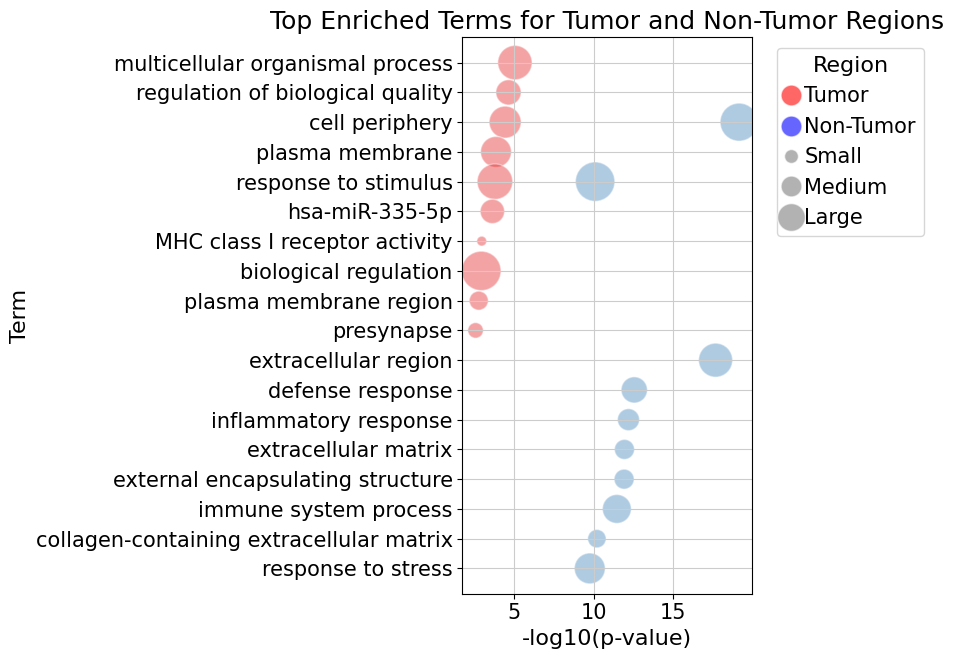

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 假设数据已经加载到 enrichment_tumor 和 enrichment_nontumor
# 选择前20个富集术语进行可视化
top_terms = 20
enrichment_tumor = enrichment_tumor.head(top_terms)
enrichment_nontumor = enrichment_nontumor.head(top_terms)

# 将富集分析结果合并到一个数据框中
enrichment_tumor['region'] = 'Tumor'
enrichment_nontumor['region'] = 'Non-Tumor'
combined_enrichment = pd.concat([enrichment_tumor, enrichment_nontumor])

# 绘制气泡图对比肿瘤区域和非肿瘤区域的富集分析结果
plt.figure(figsize=(10, 7))

# 修改散点图绘制
scatter = sns.scatterplot(data=combined_enrichment, 
                          x=-np.log10(combined_enrichment['p_value']), 
                          y='name', 
                          size='intersection_size', 
                          hue='region', 
                          palette='Set1', # 使用Set1调色板
                          sizes=(50, 800), 
                          alpha=0.4, # 设置透明度
                          legend=False) # 先不显示图例

# 获取图例句柄和标签
handles, labels = scatter.get_legend_handles_labels()

# 构建自定义图例
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=15, label='Tumor', alpha=0.6),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15, label='Non-Tumor', alpha=0.6),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Small', alpha=0.6),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=15, label='Medium', alpha=0.6),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=20, label='Large', alpha=0.6)
]

# 添加自定义图例
plt.legend(handles=legend_elements, title='Region', title_fontsize='16', fontsize='15', bbox_to_anchor=(1.05, 1), loc='upper left')

# 添加标题和标签
plt.xlabel('-log10(p-value)', fontsize=16)
plt.ylabel('Term', fontsize=16)
plt.title('Top Enriched Terms for Tumor and Non-Tumor Regions', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

# 显示图表
plt.show()


In [23]:
pre.to_csv('/data/SPACEL-l/docs/data/melanoma/spacel_data.csv', index=False,float_format='%.6f')

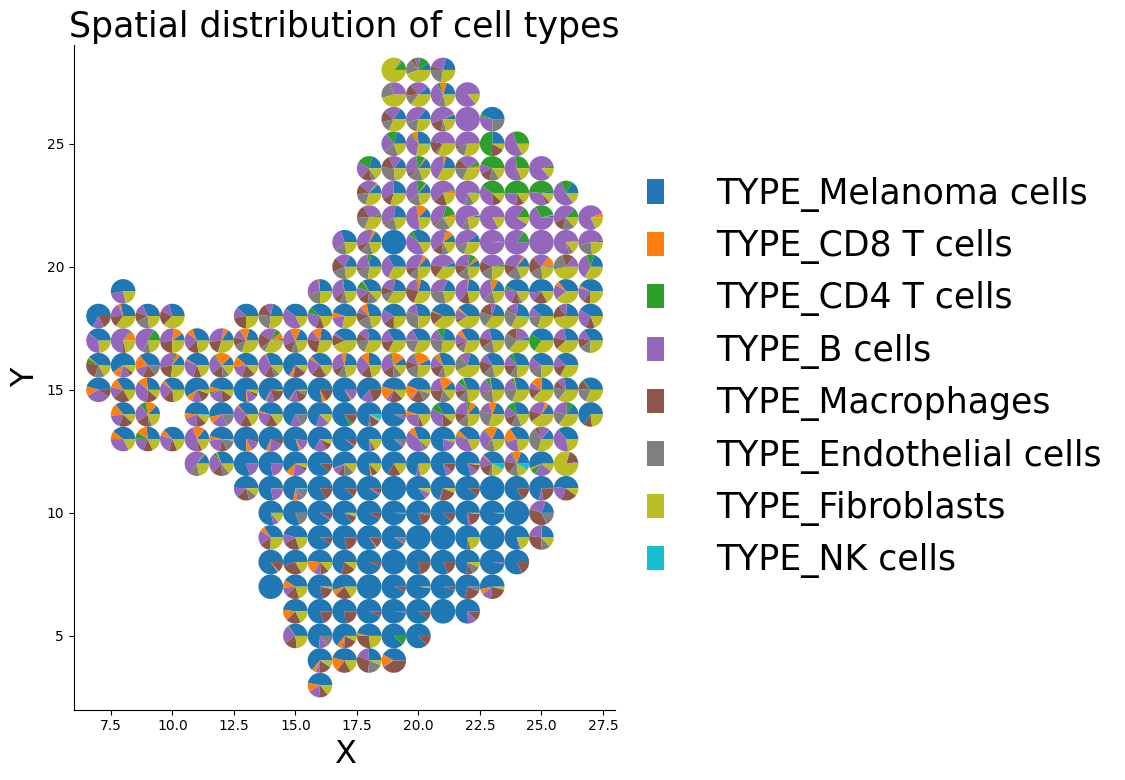

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

# 读取位置文件
st_loc_file = "/data/Celloc-main/data/CytoSPACE_example_melanoma/melanoma_STdata_slide1_coordinates.txt"
st_loc_df = pd.read_csv(st_loc_file, sep="\t")

# 读取预测文件
predicted_values = pd.read_csv('/data/SPACEL-l/docs/data/melanoma/spacel_data.csv')

# 重置索引
st_loc_df.reset_index(drop=True, inplace=True)
predicted_values.reset_index(drop=True, inplace=True)

# 合并数据
merged_data = pd.concat([st_loc_df, predicted_values], axis=1)

# 确保所有细胞类型数据列都是数值类型
for col in merged_data.columns[3:]:  # 假设前三列是非细胞类型数据列
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# 确保 X 和 Y 列是数值类型
merged_data['X'] = pd.to_numeric(merged_data['X'], errors='coerce')
merged_data['Y'] = pd.to_numeric(merged_data['Y'], errors='coerce')

# 删除包含缺失值的行
merged_data.dropna(subset=['X', 'Y'], inplace=True)

# 定义绘制饼图的函数
def draw_pie(ax, sizes, x, y, colors):
    start_angle = 0
    radius = 0.5  # 缩小饼图的半径
    for size, color in zip(sizes, colors):
        angle = size * 360
        wedge = Wedge((x, y), radius, start_angle, start_angle + angle, facecolor=color)
        ax.add_patch(wedge)
        start_angle += angle

# 设置颜色
colors = plt.cm.tab10(np.linspace(0, 1, predicted_values.shape[1]))

# 创建绘图
fig, ax = plt.subplots(figsize=(13, 8))
for _, row in merged_data.iterrows():
    sizes = row[3:] / row[3:].sum()  # 细胞类型的比例数据
    x = row['X']
    y = row['Y']
    draw_pie(ax, sizes, x, y, colors)

# 设置标题和标签
ax.set_title('Spatial distribution of cell types', fontsize=25)
ax.set_xlabel('X', fontsize=23)
ax.set_ylabel('Y', fontsize=23)

# 设置坐标轴
ax.set_xlim(merged_data['X'].min() - 1, merged_data['X'].max() + 1)
ax.set_ylim(merged_data['Y'].min() - 1, merged_data['Y'].max() + 1)
ax.set_aspect('equal')
plt.grid(False)

# 去掉顶部和右侧的坐标轴线
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 添加图例
cell_types = predicted_values.columns
handles = [Wedge((0, 0), 1, 0, 360, facecolor=color) for color in colors]
ax.legend(handles, cell_types, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=25, handletextpad=1.5, columnspacing=2)

# 显示图表
plt.tight_layout()
plt.show()


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
ranking genes


/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_CellType']`


/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


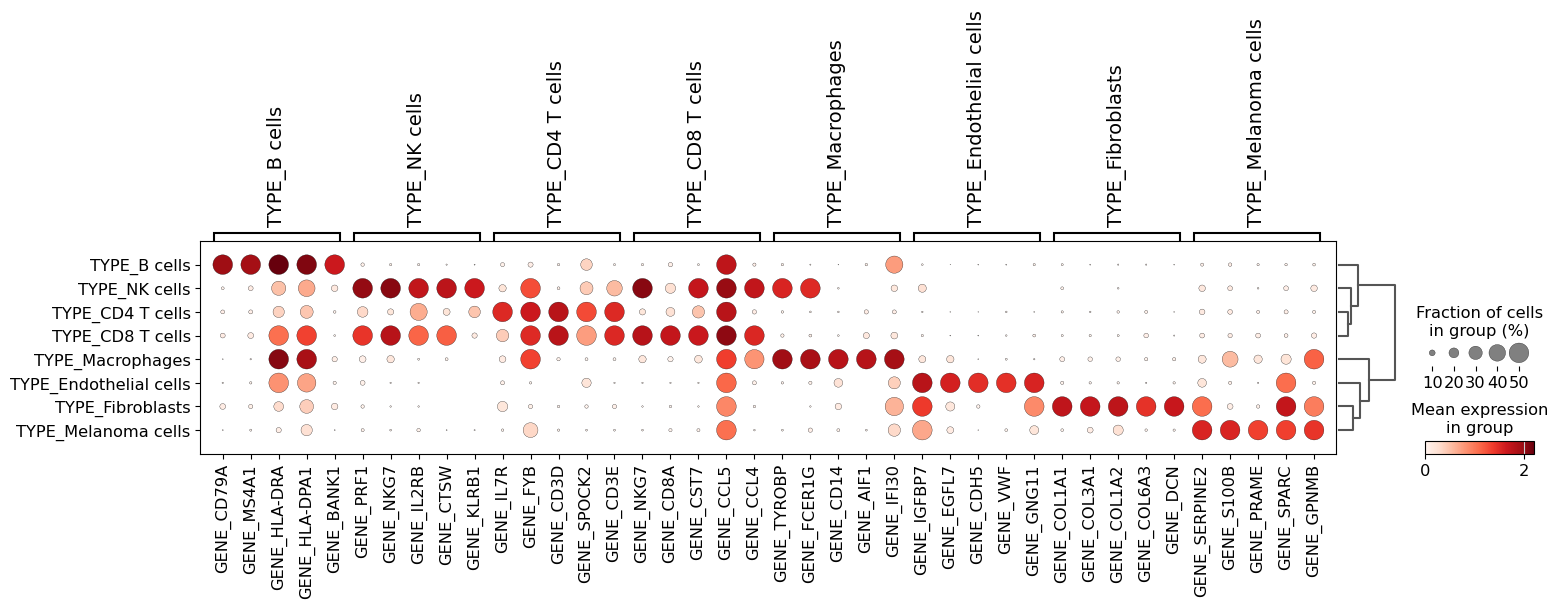

In [25]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
# 加载数据
# 假设 scadata 是一个已加载的 AnnData 对象
sc_adata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_melanoma/scRNA.h5ad')
# 数据预处理
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)
sc.pp.highly_variable_genes(sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc_adata = sc_adata[:, sc_adata.var.highly_variable]

# 差异表达分析
groupby = 'CellType'  # 假设你的细胞类型信息存储在 'CellType' 列
sc.tl.rank_genes_groups(sc_adata, groupby=groupby, method='wilcoxon')

# 选择关键基因
result = sc_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 为每个群体选择前10个显著差异表达的基因
top_genes = {}
for group in groups:
    top_genes[group] = result['names'][group][:5]

# 将选择的基因放入一个列表
selected_genes = [gene for group in top_genes.values() for gene in group]

# 确保选择的基因在数据中
selected_genes = [gene for gene in selected_genes if gene in sc_adata.var_names]

# 创建 marker_genes_dict
marker_genes_dict = {group: top_genes[group] for group in groups}

# 生成点图
# 生成点图，并调整字体大小和点的大小


# # 调整点的大小
# for artist in dotplot_dict['mainplot_ax'].collections:
#     artist.set_sizes([50])  # 设置点的大小

# # 调整字体大小
# for text in dotplot_dict['mainplot_ax'].texts:
#     text.set_fontsize(20)  # 设置字体大小
sc.pl.dotplot(sc_adata, marker_genes_dict, groupby=groupby, dendrogram=True, dot_max=0.5, var_group_positions={'var_group': 5.0})
plt.show()



In [26]:
sc_adata

AnnData object with n_obs × n_vars = 4139 × 4696
    obs: 'CellType'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg', 'rank_genes_groups', 'dendrogram_CellType'
    obsm: 'X_pca'
    varm: 'PCs'

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
ranking genes


/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


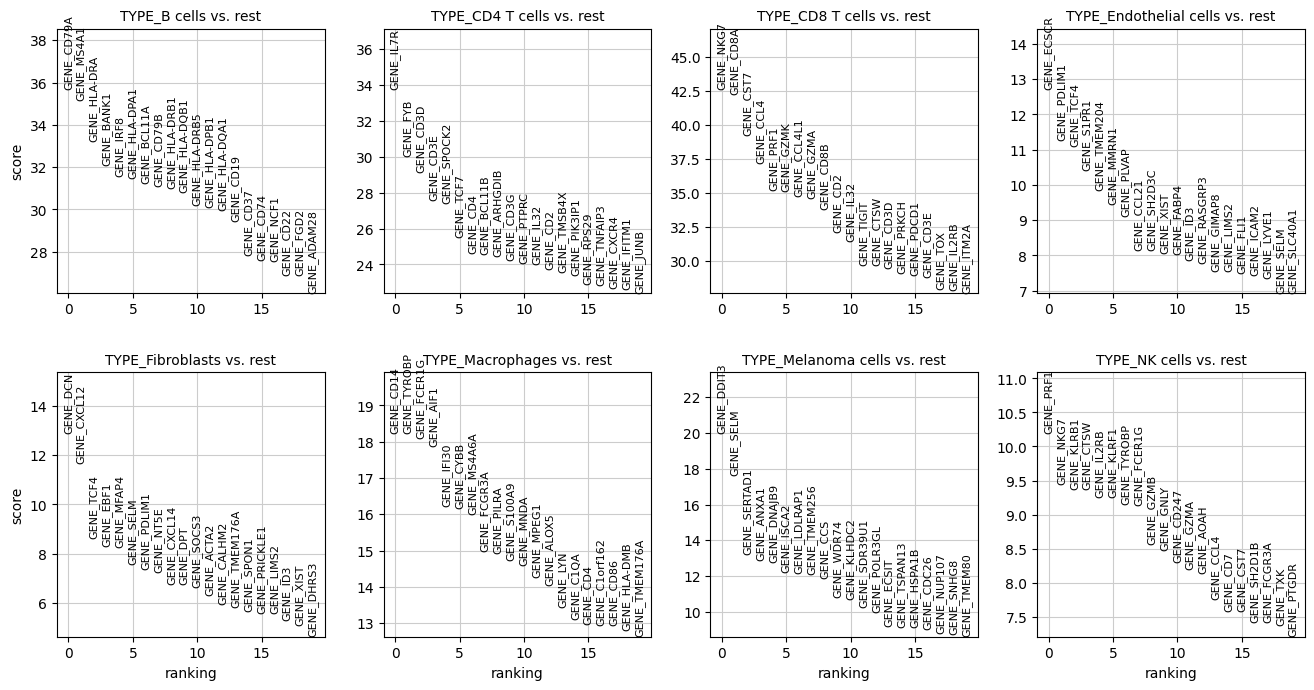

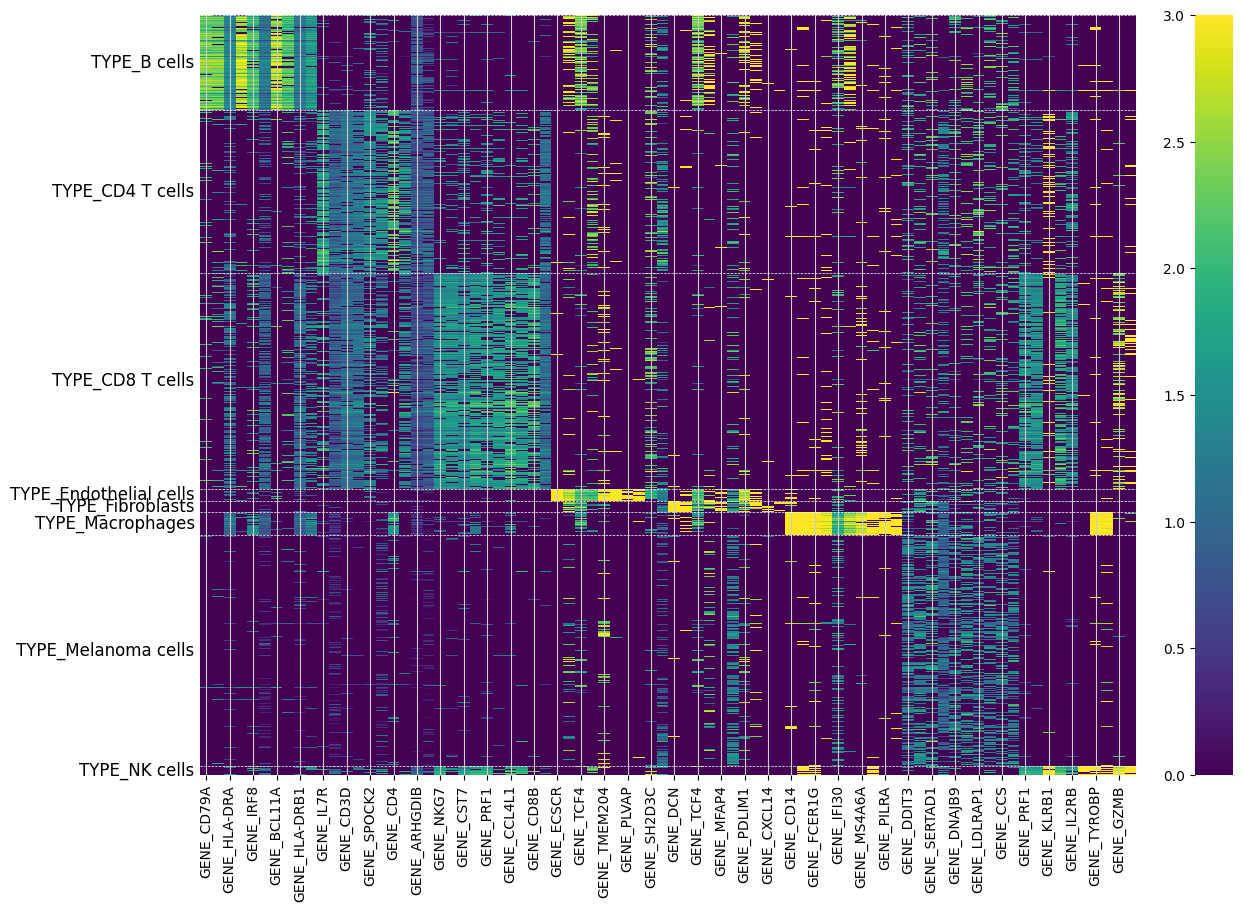

In [27]:
import scanpy as sc
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据
# 假设 sc_adata 是一个已加载的 AnnData 对象
# 数据预处理
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)
sc.pp.highly_variable_genes(sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc_adata = sc_adata[:, sc_adata.var.highly_variable]

# 差异表达分析
groupby = 'CellType'  # 假设你的细胞类型信息存储在 'CellType' 列
sc.tl.rank_genes_groups(sc_adata, groupby=groupby, method='wilcoxon')
sc.pl.rank_genes_groups(sc_adata, n_genes=20, sharey=False)

# 选择关键基因
result = sc_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 为每个群体选择前10个显著差异表达的基因
top_genes = {}
for group in groups:
    top_genes[group] = result['names'][group][:10]

# 将选择的基因放入一个列表
selected_genes = [gene for group in top_genes.values() for gene in group]

# 提取这些基因的表达数据
expr_data = pd.DataFrame(sc_adata.X, index=sc_adata.obs_names, columns=sc_adata.var_names)
expr_data_selected = expr_data[selected_genes]

# 获取细胞类型信息
cell_types = sc_adata.obs[groupby]

# 对数据进行标准化处理
scaler = StandardScaler()
expr_data_scaled = scaler.fit_transform(expr_data_selected)
expr_data_scaled = pd.DataFrame(expr_data_scaled, index=expr_data_selected.index, columns=expr_data_selected.columns)

# 将细胞类型信息添加到标准化数据中
expr_data_scaled['CellType'] = cell_types

# 按细胞类型排序
expr_data_scaled = expr_data_scaled.sort_values('CellType')

# 删除用于排序的细胞类型列
cell_type_order = expr_data_scaled['CellType']
expr_data_scaled = expr_data_scaled.drop(columns=['CellType'])

# 生成热图
plt.figure(figsize=(15, 10))

# 绘制热图并设置颜色条范围和位置
heatmap = sns.heatmap(expr_data_scaled, cmap="viridis", yticklabels=False, vmin=0, vmax=3, cbar=True)

# 获取颜色条对象并将其移动到左侧
cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')

# 设置热图的标题和轴标签
# plt.title("Heatmap of Selected Genes")
# plt.xlabel("Genes")
# plt.ylabel("Cells")

# 添加细胞类型的分区线和标签
unique_cell_types = cell_type_order.unique()
current_pos = 0
for cell_type in unique_cell_types:
    cell_count = cell_type_order[cell_type_order == cell_type].shape[0]
    plt.axhline(current_pos, color='white', linestyle='--', linewidth=0.5)  # 分割线变细
    plt.text(-0.5, current_pos + cell_count / 2, cell_type, verticalalignment='center', fontsize=12, color='black', ha='right')  # 注释放在热图左侧
    current_pos += cell_count

plt.show()


In [28]:
import pandas as pd

# 假设您已经有差异表达分析结果
result = sc_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 定义显著性的标准，例如p值和log fold change
pval_threshold = 0.05
logfoldchange_threshold = 1.5

# 创建一个空的DataFrame用于存储显著差异表达基因
significant_genes = pd.DataFrame()

for group in groups:
    # 提取该组别的基因名称、p值和log fold change
    gene_names = result['names'][group]
    pvals = result['pvals'][group]
    logfoldchanges = result['logfoldchanges'][group]
    
    # 创建DataFrame
    df = pd.DataFrame({
        'gene': gene_names,
        'pval': pvals,
        'logfoldchange': logfoldchanges
    })
    
    # 筛选显著差异表达基因
    significant = df[(df['pval'] < pval_threshold) & (abs(df['logfoldchange']) > logfoldchange_threshold)]
    
    # 添加group信息
    significant['group'] = group
    
    # 合并到总的DataFrame中
    significant_genes = pd.concat([significant_genes, significant], ignore_index=True)

# 移除基因名称中的 "GENE_" 前缀
significant_genes['gene'] = significant_genes['gene'].str.replace('GENE_', '')

# 输出显著差异表达基因
print(significant_genes)

# 将显著差异表达基因保存为xls文件
with pd.ExcelWriter('significant_genes.xlsx') as writer:
    significant_genes.to_excel(writer, index=False, sheet_name='Significant Genes')


/tmp/ipykernel_279307/403356985.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant['group'] = group
/tmp/ipykernel_279307/403356985.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant['group'] = group
/tmp/ipykernel_279307/403356985.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

         gene           pval  logfoldchange          group
0       CD79A  1.498743e-278       7.098869   TYPE_B cells
1       MS4A1  7.112445e-271       6.760343   TYPE_B cells
2     HLA-DRA  1.091224e-241       3.771781   TYPE_B cells
3       BANK1  1.056894e-225       7.634591   TYPE_B cells
4        IRF8  1.003132e-218       5.113318   TYPE_B cells
...       ...            ...            ...            ...
2418     CD27   8.170988e-04      -2.272384  TYPE_NK cells
2419  HLA-DMA   6.814874e-04      -2.703453  TYPE_NK cells
2420    RGS10   6.199562e-04      -2.490588  TYPE_NK cells
2421   HSPA1B   4.019287e-04      -2.154901  TYPE_NK cells
2422     CD3D   6.015180e-08      -4.556788  TYPE_NK cells

[2423 rows x 4 columns]


In [29]:
import pandas as pd
from gprofiler import GProfiler

# 假设您已经有一个差异表达分析的结果
result = sc_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 提取显著差异表达的基因
gene_list = pd.DataFrame({
    group: result['names'][group]
    for group in groups
})

# 使用gprofiler进行富集分析
gp = GProfiler(return_dataframe=True)

# GO Biological Process富集分析
enr_go_bp = gp.profile(organism='hsapiens', query=gene_list[groups[0]].tolist(), sources=['GO:BP'])

# 打印结果
print("GO BP Enrichment Results")
print(enr_go_bp.head())

# KEGG富集分析
enr_kegg = gp.profile(organism='hsapiens', query=gene_list[groups[0]].tolist(), sources=['KEGG'])

# 打印结果
print("KEGG Enrichment Results")
print(enr_kegg.head())

# 可视化结果（如有需要）
import matplotlib.pyplot as plt
import seaborn as sns

def plot_enrichment_results(enrichment_results, title):
    plt.figure(figsize=(10, 8))
    sns.barplot(x='p_value', y='term_name', data=enrichment_results.sort_values(by='p_value').head(20))
    plt.title(title)
    plt.xlabel('p-value')
    plt.ylabel('Enriched Terms')
    plt.tight_layout()
    plt.show()

plot_enrichment_results(enr_go_bp, 'GO BP Enrichment Analysis')
plot_enrichment_results(enr_kegg, 'KEGG Enrichment Analysis')


ConnectionError: HTTPSConnectionPool(host='biit.cs.ut.ee', port=443): Max retries exceeded with url: /gprofiler/api/gost/profile/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f43d554b460>: Failed to establish a new connection: [Errno 110] Connection timed out'))

In [ ]:
import scanpy as sc
import gseapy as gp
import pandas as pd

# 读取数据
sc_adata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_melanoma/scRNA.h5ad')

# 进行差异表达分析（假设你已经有了差异表达分析的结果）
# 你可以使用sc.tl.rank_genes_groups进行差异表达分析，这里我们假设你已经有了结果
result = sc_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 提取差异表达基因（以logfoldchange为排序依据）
gene_list = pd.DataFrame({
    group: result['names'][group]
    for group in groups
})

# 提取基因名称和log2 fold change
gene_scores = pd.DataFrame({
    group: result['logfoldchanges'][group]
    for group in groups
})

# 选择要进行富集分析的基因集
gene_set = 'GO_Biological_Process_2021'  # 或者 'KEGG_2019_Human' 等等

# 进行富集分析
enr = gp.enrichr(
    gene_list=gene_list[groups[0]],  # 选择一个特定的组别
    description='pathway',
    gene_sets=gene_set,
    outdir=None,  # 设置为None以避免创建输出目录
    cutoff=0.05,  # p值阈值
)

# 打印结果
print(enr.results.head())

# 可视化结果
gp.plot.barplot(enr.results, title='Enrichment Analysis', ofname='enrichment_analysis.png')


KeyError: 'rank_genes_groups'

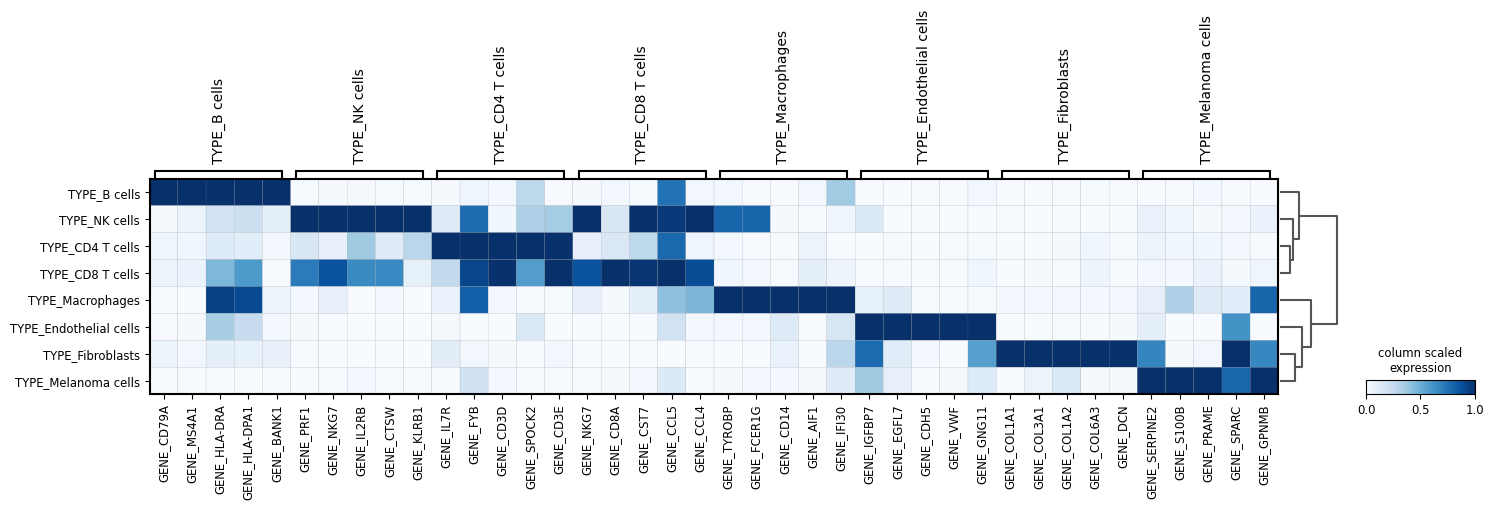

In [ ]:
sc.pl.matrixplot(
    sc_adata,
    marker_genes_dict,
    "CellType",
    dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

In [ ]:
# scale and store results in layer
sc_adata.layers["scaled"] = sc.pp.scale(sc_adata, copy=True).X

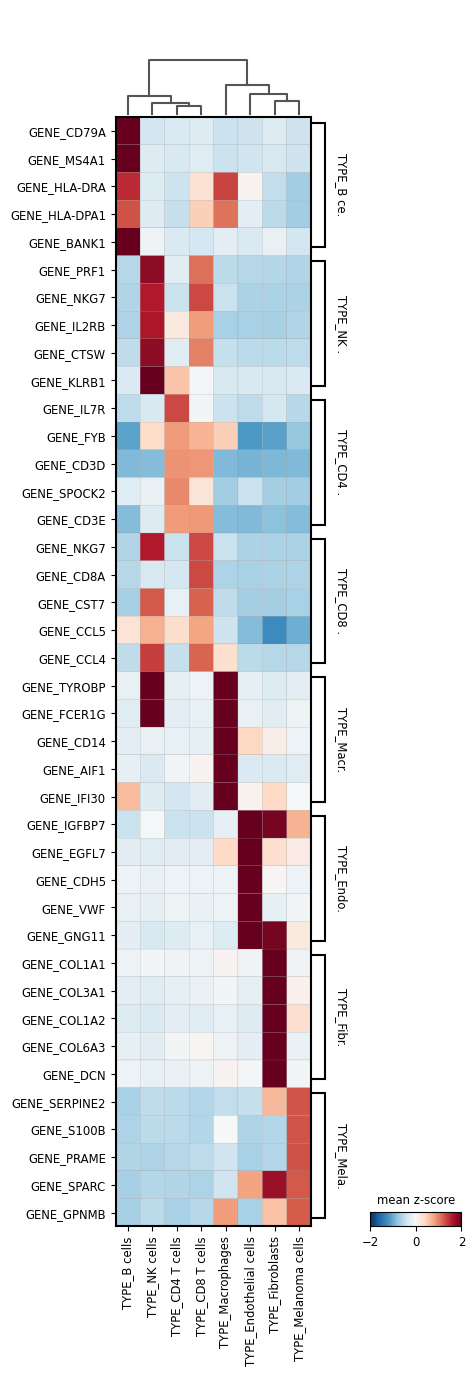

In [ ]:
sc.pl.matrixplot(
    sc_adata,
    marker_genes_dict,
    "CellType",
    dendrogram=True,
    colorbar_title="mean z-score",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    swap_axes=True
)

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


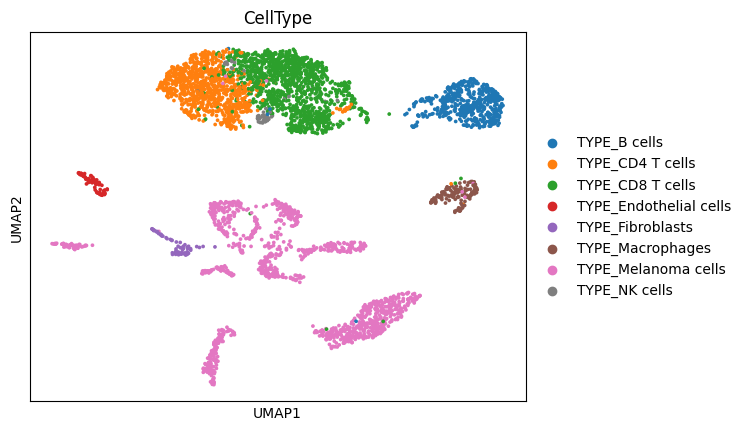

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


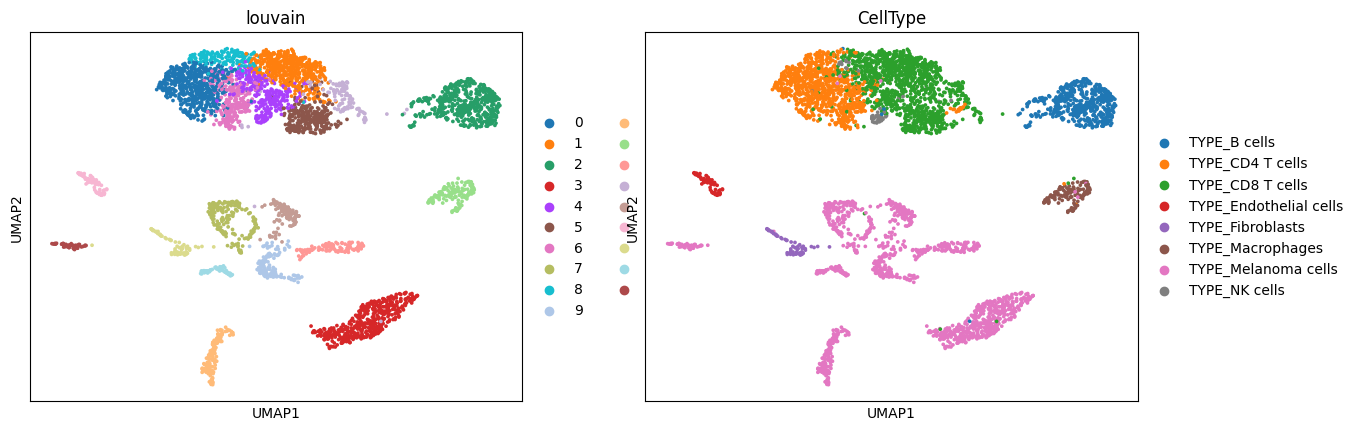

In [ ]:
import scanpy as sc

# 数据预处理
sc.pp.filter_cells(sc_adata, min_genes=200)
sc.pp.filter_genes(sc_adata, min_cells=3)
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)


# PCA降维
sc.tl.pca(sc_adata, svd_solver='arpack')

# 使用UMAP进行可视化
sc.pp.neighbors(sc_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(sc_adata)
sc.pl.umap(sc_adata, color=['CellType'])

# 聚类分析
sc.tl.louvain(sc_adata)
sc.pl.umap(sc_adata, color=['louvain', 'CellType'])


In [ ]:
import scanpy as sc


# 计算最近邻居
sc.pp.neighbors(sc_adata, n_neighbors=15, use_rep='X_pca')

# 使用leiden聚类
sc.tl.leiden(
    sc_adata,
    key_added="clusters",
    resolution=0.5,
    n_iterations=2,
    directed=False,
)

# 输出聚类结果
print(sc_adata.obs['clusters'])


CELL_CY72.CD45.H02.S758.COMB          2
CELL_CY58.1.CD45.B02.S974.COMB        1
CELL_CY71.CD45.D08.S524.COMB         15
CELL_CY81.FNA.CD45.B01.S301.COMB      7
CELL_CY80.II.CD45.B07.S883.COMB       6
                                     ..
CELL_CY75.1.CD45.CD8.1..S25.COMB      4
CELL_CY75.1.CD45.CD8.7..S223.COMB     4
CELL_CY75.1.CD45.CD8.1..S65.COMB      1
CELL_CY75.1.CD45.CD8.1..S93.COMB      4
CELL_CY75.1.CD45.CD8.1..S76.COMB      4
Name: clusters, Length: 4139, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']


categories: 0, 1, 2, etc.
var_group_labels: TYPE_B cells, TYPE_CD4 T cells, TYPE_CD8 T cells, etc.


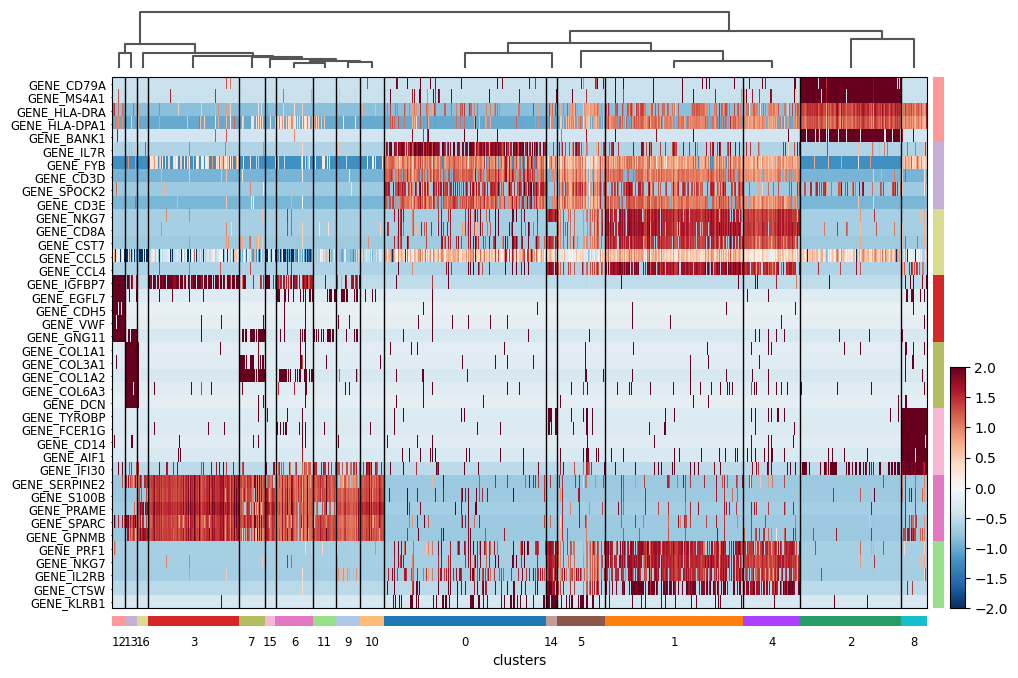

AttributeError: 'NoneType' object has no attribute 'ax_heatmap'

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt


# 绘制热图
ax = sc.pl.heatmap(
    sc_adata,
    marker_genes_dict,
    groupby="clusters",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    dendrogram=True,
    swap_axes=True,
    figsize=(11, 8),  # 增加图像高度
)

# 旋转和调整基因标签的字体大小
for ax in ax.ax_heatmap.get_yticklabels():
    ax.set_rotation(0)  # 将旋转角度设置为0，即水平显示
    ax.set_fontsize(10)  # 根据需要调整字体大小

plt.show()


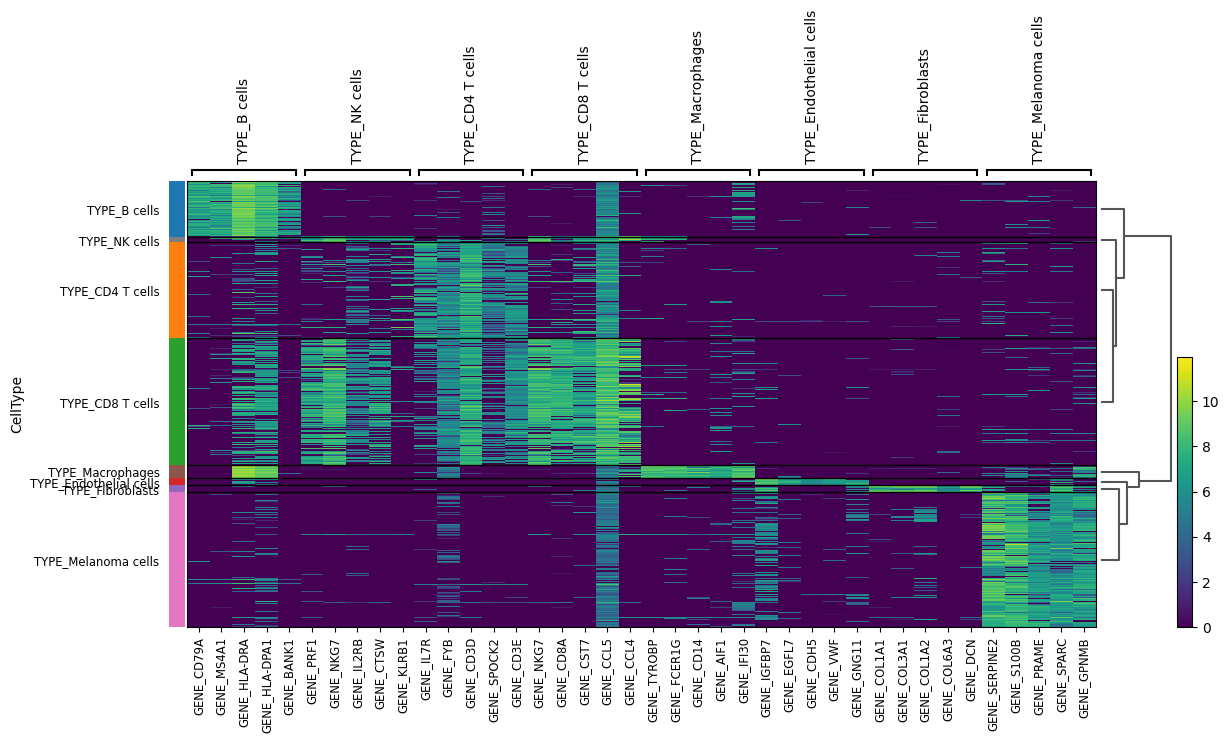

In [ ]:
ax = sc.pl.heatmap(
    scadata, marker_genes_dict, groupby="CellType", cmap="viridis", dendrogram=True
)

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


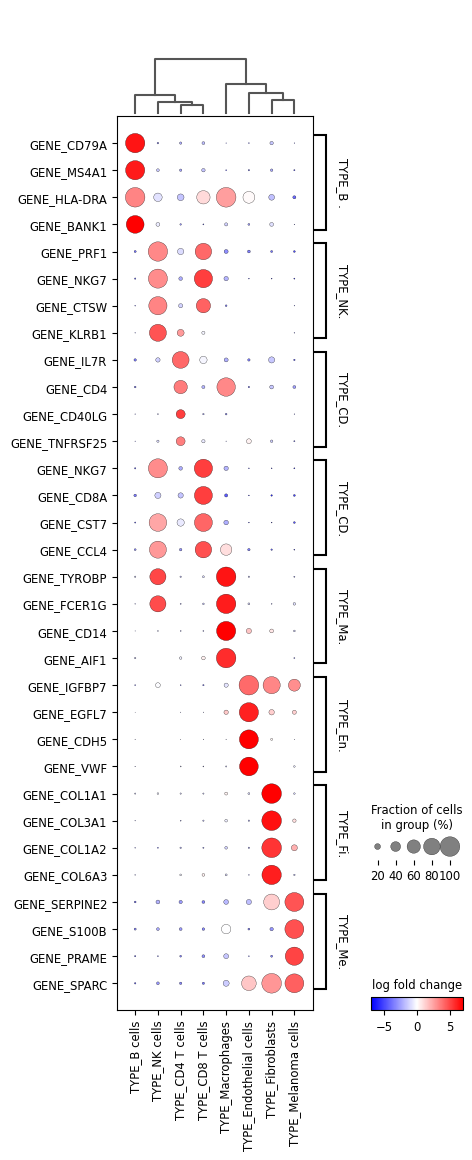

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    sc_adata,
    n_genes=4,
    values_to_plot="logfoldchanges",
    min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap="bwr",
    swap_axes=True 
)

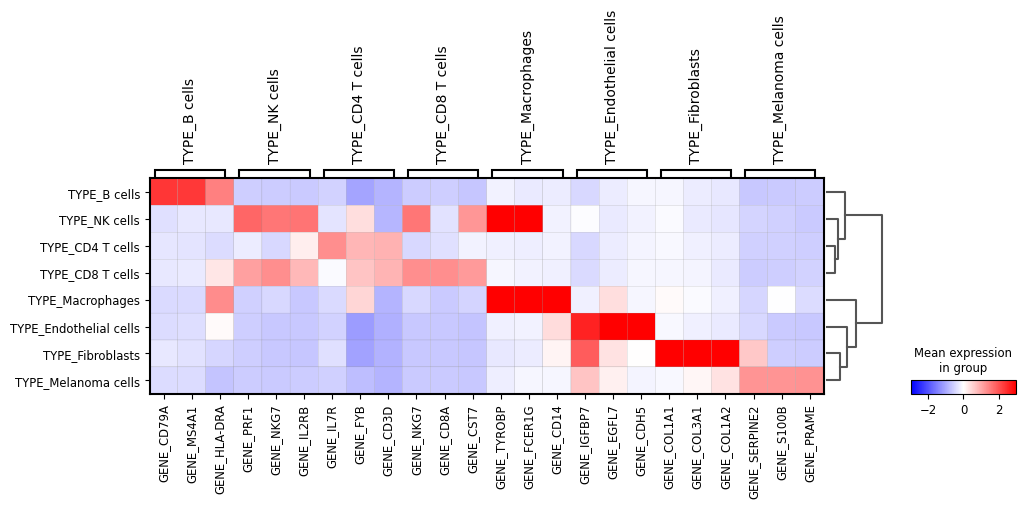

In [ ]:
sc.pl.rank_genes_groups_matrixplot(
    sc_adata, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap="bwr", layer="scaled"
)

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and 

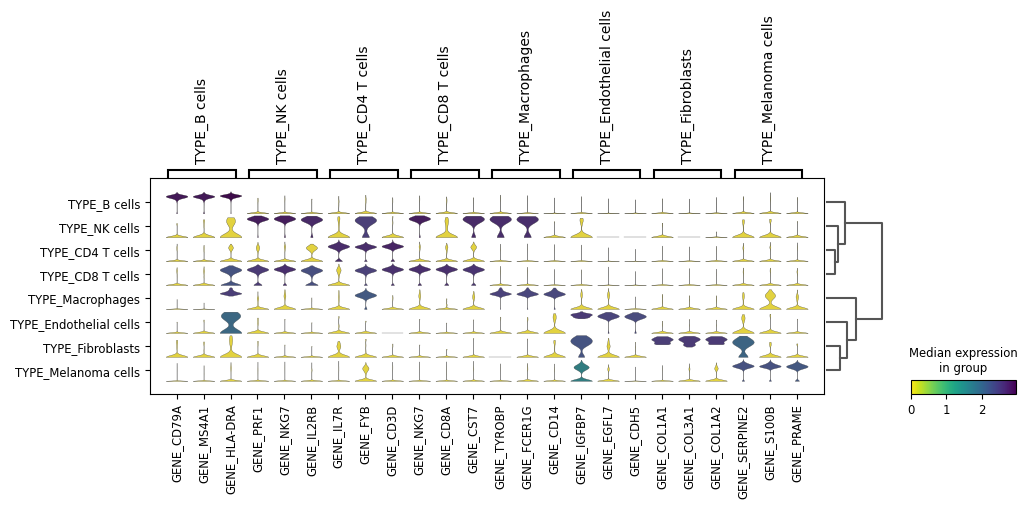

In [ ]:
sc.pl.rank_genes_groups_stacked_violin(sc_adata, n_genes=3, cmap="viridis_r")